In [93]:
# 라이브러리 및 모듈 import
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as patches

In [94]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        
        # coco annotation 불러오기 (by. coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        # image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # boxes (x, y, w, h)
        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        # box별 label
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            while True:
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.tensor(sample['labels'])
                    break
            
        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [95]:
# Albumentation을 이용, augmentation 선언
def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        # A.Flip(p=0.5),
        # ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    return tuple(zip(*batch))

In [121]:
class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [
    [250,0,50], 
    [0, 255, 0], 
    [0, 180, 80], 
    [185, 185, 185], 
    [100, 100, 100], 
    [200, 50, 150], 
    [50, 150, 200], 
    [50, 200, 150], 
    [200, 200, 200], 
    [255,255,255], 
]
class_color_list = [(np.array(RGB)/255).tolist() for RGB in class_color_list]
# print(class_color_list)

annotation = './dataset/train.json'
data_dir = './dataset'
train_dataset = CustomDataset(annotation, data_dir, get_train_transform())

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


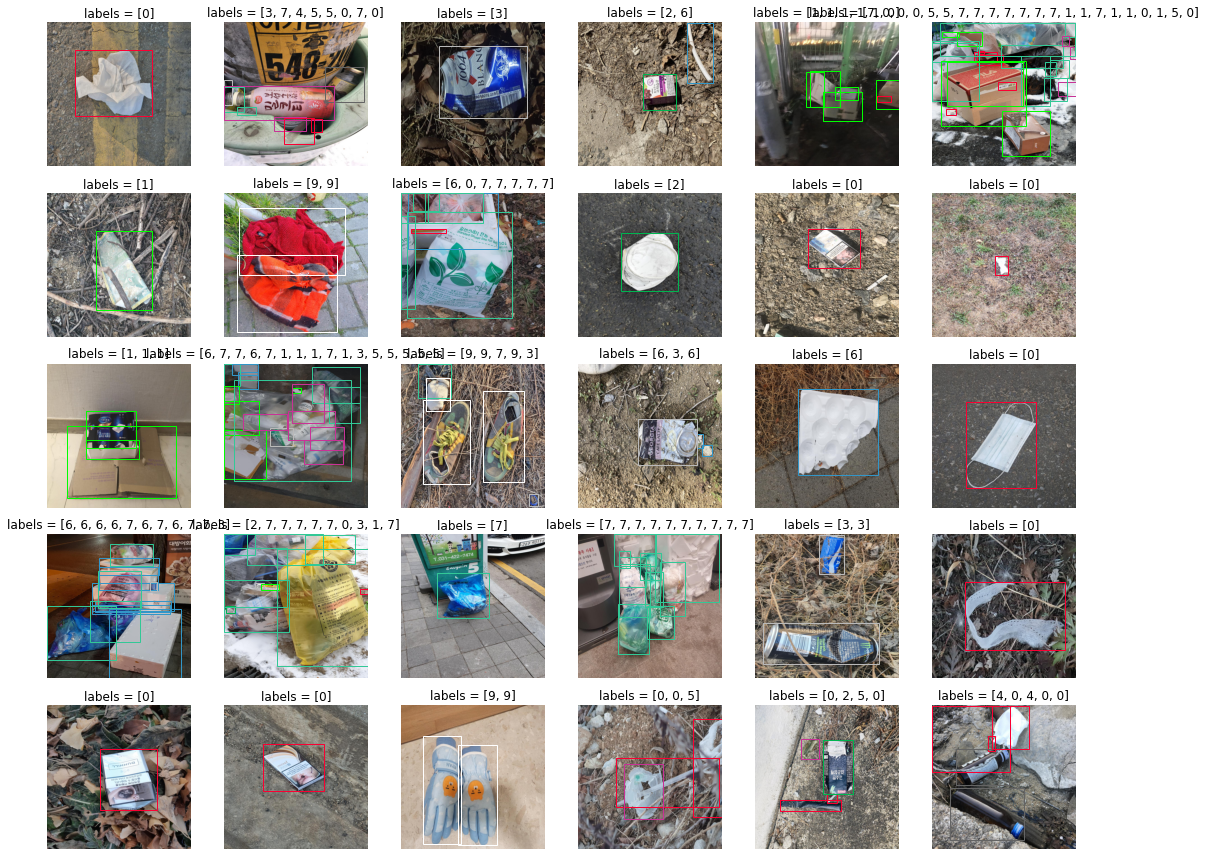

In [124]:
n_rows, n_cols = 5, 6 
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))

for row in range(n_rows):
    for col in range(n_cols):
        image, target, image_id = train_dataset[row*n_cols+col]
        axes[row, col].imshow(image)
        axes[row, col].set_title(f"labels = {list(target['labels'].numpy())}")
        axes[row, col].axis('off')

        for box, label in zip(target['boxes'], target['labels']):
            y_min, x_min, y_max, x_max = box
            # x_min, y_min, x_max, y_max 
            rect = patches.Rectangle(
                    # (x_max, y_min),
                    (x_min, y_min),
                    x_max-x_min,
                    y_max-y_min,
                    # edgecolor = class_color_list[label],
                    # edgecolor = 'blue',
                    edgecolor = class_color_list[label],
                    facecolor = 'red',
                    fill=False
            ) 
            axes[row, col].add_patch(rect)
        print()

plt.tight_layout()
plt.show()



In [115]:
np.array([255,255,255])/255

array([1., 1., 1.])